# Задача

- [x] Самостоятельно реализовать функцию **gradient_descent(X, y)**, которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал **методом градиентного спуска (Batch Gradient Descent, GD)** и возвращая вектор весов **w**. В качестве функционала можно выбрать, например, функцию ошибок **MSE** + $L_2$-регуляризатор. Использовать матрично-векторные операции для вычисления градиента.
- [x] Найти данные, на которых интересно будет решать задачу регрессии. Зависимость целевого признака от нецелевых должна быть не слишком сложной, чтобы обученная линейная модель смогла показать приемлимый результат. В крайнем случае взять данные для предсказания стоимости машин [тут](https://github.com/rustam-azimov/ml-course-itmo/tree/main/data/car_price) (целевой признак для предсказания --- **price**).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Случайным образом разбить данные на **обучающую** и **тестовую** выборки, используя методы существующих библиотек.
- [x] При обучении моделей использовать **масштабирование данных**.
- [x] Обучить модель на обучающей выборке, используя функцию **gradient_descent(X, y)**. Оценить качество модели на обучающей и тестовой выборках, используя **MSE**, **RMSE** и $R^2$.
- [x] Обучить модель, используя существующую библиотеку. Например, в **sklearn** для $L_2$-регуляризатора можно использовать **Ridge**. Сравнить качество с Вашей реализацией.
- [x] Повторить тоже самое, но используя **кросс-валидацию**.
- [x] Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, STD), где k --- количество фолдов в кросс-валидации, **E** --- мат. ожидание и **STD** --- стандартное отклонение. Сделать выводы.
- [x] (+2 балла) Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя **Recursive Feature Elimination (RFE)** из **sklearn**.
- [x] (+1 балл) Во все ваши реализации добавить возможность настройки нужных **гиперпараметров**, а в процессе обучения **всех** моделей осуществить подбор оптимальных значений этих гиперпараметров.
- [x] (+1 балл) Также самостоятельно реализовать **метод стохастического градиентного спуска (Stochastic Gradient Descent, SGD)**, обучить модели и добавить их во все сравнения.
- [x] (+1 балл) Также самостоятельно реализовать **метод мини-пакетного градиентного спуска (Mini Batch Gradient Descent)**, обучить модели и добавить их во все сравнения.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

%precision %.4f
import warnings
warnings.filterwarnings('ignore')


Выбранный датасет можно скачать [тут](https://www.kaggle.com/datasets/talhabarkaatahmad/pakistan-used-car-prices-2023/data). В нем содержится информация о продажах машин. Эти данные были взяты с веб-сайта PakWheels.



Признаки:
* **ad_ref** - уникальный идентификатор
* **city** - город, в котором был продан автомобил
* **assembly** - импортирован или нет
* **body** - тип кузова
* **make** - марка
* **model** - модель
* **year** - год производства
* **engine_cc** - объем двигателя
* **transmission** - тип коробки передач
* **fuel_type** - тип топлива
* **color** - цвет
* **registered** - город, в котором автомобиль зарегистрирован
* **mileage** - пробег
* **price** (целевой признак) - цена продажи (в пакистанских рупиях)

In [2]:
df = pd.read_csv('/content/pakwheels_used_car_data_v02.csv')

# Базовая информация о датасете

In [3]:
df.head()

,addref,city,assembly,body,make,model,year,engine,transmission,fuel,color,registered,mileage,price
0,7943732,Peshawar,NaN,Sedan,Toyota,Corolla,2013.0,1300.0,Manual,Petrol,Silver Metallic,Lahore,145000,2870000.0
1,7730314,Lahore,NaN,Sedan,Honda,City,2000.0,1300.0,Manual,Petrol,Blue,Lahore,230000,995000.0
2,7943737,Lahore,NaN,Sedan,Toyota,Yaris,2021.0,1300.0,Manual,Petrol,Super White,Punjab,60500,3585000.0
3,7943733,Lahore,NaN,Hatchback,Suzuki,Swift,2017.0,1300.0,Manual,Petrol,Grey,Islamabad,87000,2250000.0
4,7923484,Lahore,NaN,Sedan,Honda,Civic,2017.0,1800.0,Automatic,Petrol,Grey,Lahore,86000,4850000.0


Сразу видим, что признак *assembly* содержит пропущенные значения

In [4]:
df.describe()

,addref,year,engine,mileage,price
count,7.787800e+04,73099.000000,77875.000000,77878.000000,7.729500e+04
mean,7.809878e+06,2012.812610,1408.072550,91109.192750,3.883232e+06
std,2.599523e+05,7.516685,704.459947,89275.336173,5.759480e+06
min,2.748970e+05,1990.000000,3.000000,1.000000,1.100000e+05
25%,7.805760e+06,2007.000000,1000.000000,34000.000000,1.450000e+06
50%,7.865805e+06,2015.000000,1300.000000,80000.000000,2.700000e+06
75%,7.910334e+06,2019.000000,1600.000000,123456.000000,4.500000e+06
max,7.943741e+06,2022.000000,15000.000000,1000000.000000,5.290000e+08


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77878 entries, 0 to 77877
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   addref        77878 non-null  int64  
 1   city          77878 non-null  object 
 2   assembly      24189 non-null  object 
 3   body          68974 non-null  object 
 4   make          77878 non-null  object 
 5   model         77878 non-null  object 
 6   year          73099 non-null  float64
 7   engine        77875 non-null  float64
 8   transmission  77878 non-null  object 
 9   fuel          76972 non-null  object 
 10  color         76398 non-null  object 
 11  registered    77878 non-null  object 
 12  mileage       77878 non-null  int64  
 13  price         77295 non-null  float64
dtypes: float64(3), int64(2), object(9)
memory usage: 8.3+ MB


Категориальные признаки: **assembly**,  **body**, **transmission**, **fuel**, **mark**, **model**.

Количественные признаки: **year**, **engine**, **mileage**, **price**.

Будем предсказывать цену автомобиля (*price*) по остальным признакам.

# Чистка данных



В датасете есть запись с большим значение *price*. Удалим ее.

In [6]:
df[df['price'] > 500000000]

,addref,city,assembly,body,make,model,year,engine,transmission,fuel,color,registered,mileage,price
646,7770572,Lahore,NaN,Sedan,Toyota,Corolla,2021.0,1598.0,Manual,Petrol,Silver Metallic,Lahore,26401,529000000.0


In [7]:
df.drop(646, inplace=True)

Посмотрим на количество пропущенных значений и их долю от общего числа записей в датасете

In [8]:
count = df.isna().sum()
per = df.isna().sum() / len(df) * 100
missing_df = pd.DataFrame({'count': count, 'per, %': per})
missing_df.sort_values(by='count', ascending=False).round(2)

,count,"per, %"
assembly,53688,68.94
body,8904,11.43
year,4779,6.14
color,1480,1.90
fuel,906,1.16
price,583,0.75
engine,3,0.00
addref,0,0.00
city,0,0.00
make,0,0.00


In [9]:
df['year'].fillna(2015, inplace=True) # заполнил пропуск медианой
df = df[df['fuel'].notna()] # удалил записи с пропусками
df = df[df['price'].notna()]
df = df[df['engine'].notna()]

Наибольшее количество пропущенных значений у признака *assembly*. Уникальное значение только одно 'Imported'. Скорее всего пропущенные значения будут 'Not imported'.

In [10]:
df['assembly'].fillna('Not imported', inplace=True)

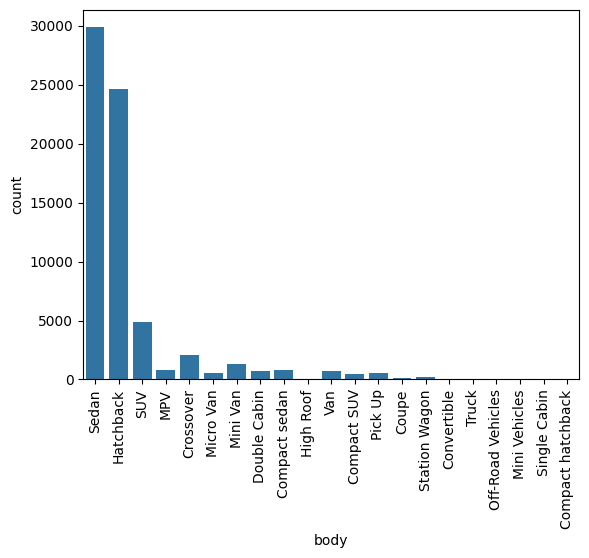

In [11]:
sns.countplot(x='body', data=df);
plt.xticks(rotation=90);

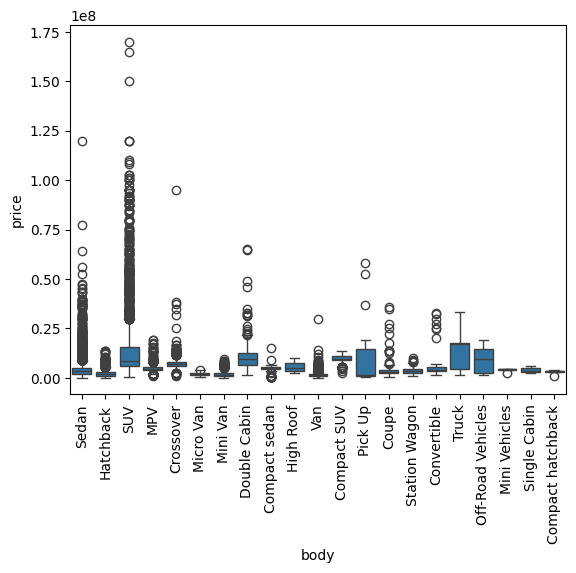

In [12]:
sns.boxplot(x='body', y='price', data=df);
plt.xticks(rotation=90);

В связи с тем, что у 11% записей в датасете отсутсвует поле *body* и на графике выше видно достаточно большое количество выбросов, удалим колонку *body*.

In [13]:
df.drop('body', axis=1, inplace=True)

In [14]:
redundant_columns = ['addref', 'city', 'color',	'registered']
df.drop(redundant_columns, axis=1, inplace=True)

In [15]:
df

,assembly,make,model,year,engine,transmission,fuel,mileage,price
0,Not imported,Toyota,Corolla,2013.0,1300.0,Manual,Petrol,145000,2870000.0
1,Not imported,Honda,City,2000.0,1300.0,Manual,Petrol,230000,995000.0
2,Not imported,Toyota,Yaris,2021.0,1300.0,Manual,Petrol,60500,3585000.0
3,Not imported,Suzuki,Swift,2017.0,1300.0,Manual,Petrol,87000,2250000.0
4,Not imported,Honda,Civic,2017.0,1800.0,Automatic,Petrol,86000,4850000.0
...,...,...,...,...,...,...,...,...,...
77873,Not imported,Honda,Civic,2019.0,1800.0,Automatic,Petrol,58000,5590000.0
77874,Imported,Suzuki,Alto,2015.0,660.0,Automatic,Petrol,65000,2420000.0
77875,Imported,MG,HS,2021.0,1490.0,Automatic,Petrol,5000,7500000.0
77876,Not imported,Suzuki,Baleno,2005.0,1300.0,Manual,Petrol,19000,1250000.0


In [16]:
df.isna().sum()

assembly        0
make            0
model           0
year            0
engine          0
transmission    0
fuel            0
mileage         0
price           0
dtype: int64

# EDA

In [17]:
df.nunique()

assembly           2
make              65
model            415
year              33
engine           188
transmission       2
fuel               3
mileage         9161
price           2305
dtype: int64

Распределение количественных переменных

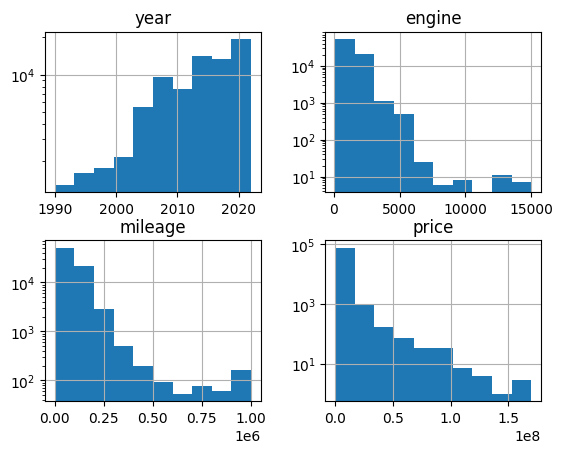

In [18]:
df.hist(column=['year', 'engine', 'mileage', 'price'], log=True);

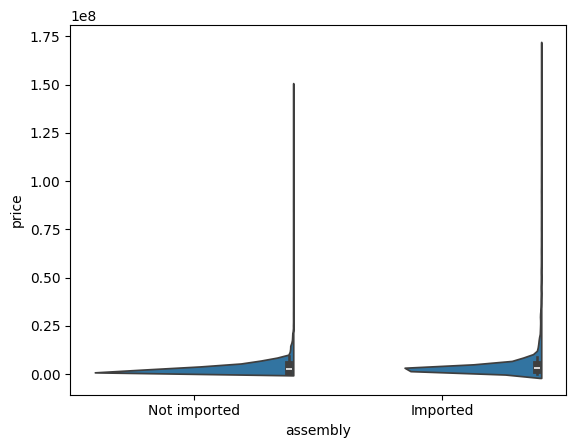

In [19]:
sns.violinplot(x='assembly', y='price', data=df, split=True);

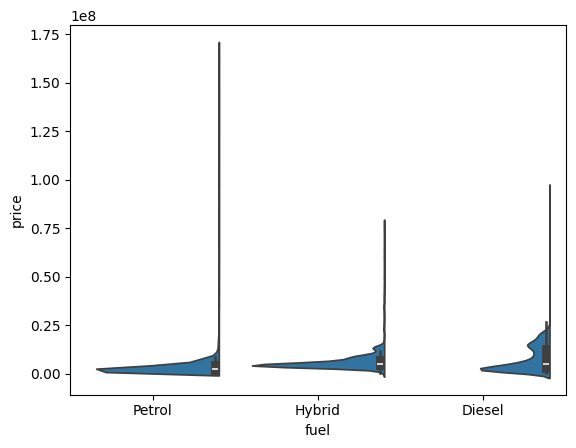

In [20]:
sns.violinplot(x='fuel', y='price', data=df, split=True);

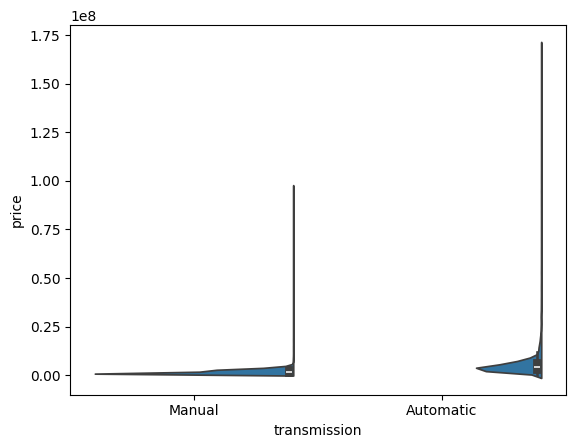

In [21]:
sns.violinplot(x='transmission', y='price', data=df, split=True);

Преобразуем категориальные признаки в количественные

In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["make"] = le.fit_transform(df["make"])
df["model"] = le.fit_transform(df["model"])
df["fuel"] = le.fit_transform(df["fuel"])
df["assembly"] = le.fit_transform(df["assembly"])
df["transmission"] = le.fit_transform(df["transmission"])

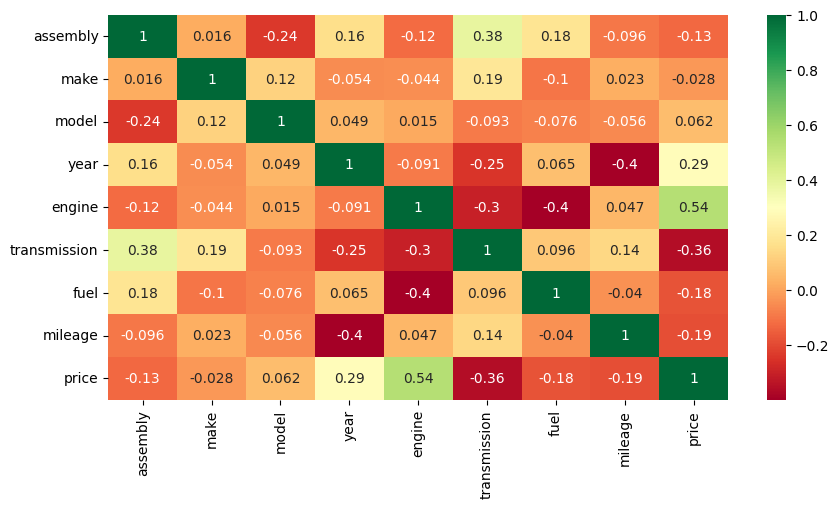

In [23]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)

Объем двигателя и год производства автомобиля больше всего коррелируют со стоимостью. Так же есть некоторая зависимость цены от типа корбки передач

# Модели линейной регрессии

In [24]:
import abc
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import (
    check_scalar, check_X_y, check_array, check_random_state, check_is_fitted
)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils.estimator_checks import check_estimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from math import ceil
from numbers import Integral, Real

Разбиение выборки на тренировочную и тестовую

In [25]:
X, y = df.drop(columns="price"), df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

Подобр наилучшего количества (и самого подмножества) признаков, используя Recursive Feature Elimination (RFE) из sklearn.

In [26]:
rfecv = RFECV(Ridge(), cv=5)
rfecv.fit(X_train, y_train)
selected_fields = X.columns[rfecv.support_]
print("Оставшиеся признаки:", set(selected_fields))
print("Удаленные признаки:", set(X.columns) - set(selected_fields))

X = X[selected_fields]
X_train = X_train[selected_fields]
X_test = X_test[selected_fields]

Оставшиеся признаки: {'fuel', 'assembly', 'transmission', 'mileage', 'year', 'model', 'engine', 'make'}
Удаленные признаки: set()


# Алгоритм линейной регрессии

In [27]:
class LinearRegressorAbstract(BaseEstimator, RegressorMixin, abc.ABC):

    def __init__(self, alpha: Real = 1, *, max_iter: Integral = 1000, tol: Real = 1e-4,
                 eta0: Real = 1):
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.eta0 = eta0

    @abc.abstractmethod
    def _get_X_y_for_GD(self, X, y):
        ...

    def fit(self, X, y):
        self.alpha = check_scalar(self.alpha, "alpha", Real, min_val=0.0)
        self.max_iter = check_scalar(self.max_iter, "max_iter", Integral, min_val=1)
        self.tol = check_scalar(self.tol, "tol", Real, min_val=0.0)
        self.eta0 = check_scalar(self.eta0, "eta0", Real, min_val=0, include_boundaries="neither")

        X, y = check_X_y(X, y, y_numeric=True)
        self.n_features_in_ = X.shape[1]
        X = np.column_stack([X, np.ones(X.shape[0])])

        coef = np.zeros(X.shape[1])
        grad = np.inf
        self.n_iter_ = 0
        while self.n_iter_ < self.max_iter and np.linalg.norm(grad) > self.tol:
            X_subset, y_subset = self._get_X_y_for_GD(X, y)
            pred = X_subset @ coef
            grad = (2 / X_subset.shape[0]) * X_subset.T @ (pred - y_subset) + 2 * self.alpha * np.pad(coef[:-1], (0, 1))
            self.n_iter_ += 1
            coef -= grad * self.eta0 / self.n_iter_

        self.coef_ = coef[:-1]
        self.intercept_ = coef[-1]

        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return X @ self.coef_ + self.intercept_


class LinearRegressorGD(LinearRegressorAbstract):
    def _get_X_y_for_GD(self, X, y):
        return X, y


class LinearRegressorMBGD(LinearRegressorAbstract):

    def __init__(self, alpha: Real = 1, batch_size: Real = 0.1, *, max_iter: Integral = 1000, tol: Real = 1e-4,
                eta0: Real = 1, random_state=None):
        super().__init__(alpha, max_iter=max_iter, tol=tol, eta0=eta0)
        self.batch_size = batch_size
        self.random_state = random_state

    def _get_X_y_for_GD(self, X, y):
        size = self.batch_size if type(self.batch_size) == int else ceil(len(X) * self.batch_size)
        idx = self.random_state_.randint(len(X), size=size)
        return X[idx, :], y[idx]

    def fit(self, X, y):
        self.batch_size = check_scalar(self.batch_size, "batch_size", (float, int), min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        return super().fit(X, y)


class LinearRegressorSGD(LinearRegressorMBGD):
    def __init__(self, alpha: Real = 1, *, max_iter: Integral = 1000, tol: Real = 1e-4, random_state=None,
                 eta0: Real = 1):
        super().__init__(alpha, 1, max_iter=max_iter, tol=tol, random_state=random_state, eta0=eta0)

# Обучение моделей

In [28]:
pd.options.display.float_format = '{:,.2f}'.format

def train_simple(regressor, estimator_name):
    model = Pipeline([("scaler", StandardScaler()), ("regressor", regressor)])
    model.fit(X_train, y_train)

    pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, pred)
    rmse_train = mean_squared_error(y_train, pred, squared=False)
    r2_train = r2_score(y_train, pred)

    pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, pred)
    rmse_test = mean_squared_error(y_test, pred, squared=False)
    r2_test = r2_score(y_test, pred)

    return [estimator_name, mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test]

data = []
data.append(train_simple(Ridge(), "Ridge"))
data.append(train_simple(LinearRegressorGD(max_iter=10000), "LinearRegressorGD"))
data.append(train_simple(LinearRegressorMBGD(random_state=50, max_iter=10000), "LinearRegressorMBGD"))
data.append(train_simple(LinearRegressorSGD(random_state=50, max_iter=10000), "LinearRegressorSGD"))

pd.DataFrame(
    data,
    columns=["Estimator", "MSE train", "MSE test", "RMSE train", "RMSE test", "R2 train", "R2 test"]
).set_index("Estimator")

,MSE train,MSE test,RMSE train,RMSE test,R2 train,R2 test
Estimator,,,,,,
Ridge,"15,470,431,275,896.01","14,953,782,229,503.51","3,933,246.91","3,867,012.05",0.43,0.42
LinearRegressorGD,"18,075,497,614,260.29","17,193,970,792,503.55","4,251,528.86","4,146,561.32",0.34,0.34
LinearRegressorMBGD,"18,075,126,841,455.69","17,193,670,427,134.20","4,251,485.25","4,146,525.10",0.34,0.34
LinearRegressorSGD,"18,260,710,432,591.15","17,375,094,806,353.47","4,273,255.25","4,168,344.37",0.33,0.33


# Обучение моделей с использованием кросс-валидации и подбором гиперпараметров

In [29]:
def train_with_param_cv(estimator, estimator_name, param_grid):
    model = Pipeline([("scaler", StandardScaler()), ("estimator", estimator)])
    param_grid = {f"estimator__{name}": val for name, val in param_grid.items()}
    grid_search = GridSearchCV(
        model,
        param_grid,
        scoring=["neg_mean_squared_error", "neg_root_mean_squared_error", "r2"],
        refit="neg_mean_squared_error",
        return_train_score=True
    )
    grid_search.fit(X, y)

    print(estimator_name)
    print(
        "Лучшие гиперпараметры:",
        {name : val for name, val in grid_search.best_params_.items()}
    )

    result = pd.DataFrame(grid_search.cv_results_).iloc[grid_search.best_index_]
    res_data = []
    res_ind = []
    column_names = []
    for i in range(1, 6):
        column_names.append(f"Fold {i}")
    column_names.append("Mean")
    column_names.append("STD")

    for score_function, name in [
        ("neg_mean_squared_error", "MSE"),
        ("neg_root_mean_squared_error", "RMSE"),
        ("r2", "R2")
    ]:
        for run_type in ["train", "test"]:
            row = []
            for i in range(5):
                row.append(abs(result[f"split{i}_{run_type}_{score_function}"]))
            row.append(abs(result[f"mean_{run_type}_{score_function}"]))
            row.append(result[f"std_{run_type}_{score_function}"])
            res_data.append(row)
            res_ind.append(f"{name} ({run_type})")

    return pd.DataFrame(
        data=res_data,
        index=res_ind,
        columns=column_names
    )

In [30]:
train_with_param_cv(
    Ridge(), "Ridge",
    {"alpha": [0.01, 0.1, 1, 4, 10]}
)

Ridge
Лучшие гиперпараметры: {'estimator__alpha': 10}


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean,STD
MSE (train),"13,358,351,990,863.06","15,173,028,174,431.61","16,393,796,064,952.29","15,458,033,804,164.06","16,051,753,188,887.00","15,286,992,644,659.61","1,055,629,693,725.44"
MSE (test),"23,600,696,728,911.45","15,885,111,477,507.97","11,010,364,240,919.98","14,800,142,543,997.81","12,515,718,425,251.29","15,562,406,683,317.70","4,365,837,642,391.39"
RMSE (train),"3,654,907.93","3,895,257.14","4,048,925.30","3,931,670.61","4,006,463.93","3,907,444.98","137,354.88"
RMSE (test),"4,858,054.83","3,985,613.06","3,318,186.89","3,847,095.34","3,537,756.13","3,909,341.25","528,637.57"
R2 (train),0.42,0.43,0.43,0.44,0.44,0.43,0.01
R2 (test),0.43,0.43,0.46,0.39,0.36,0.41,0.03


In [31]:
train_with_param_cv(
    LinearRegressorGD(), "LinearRegressorGD",
    {
        "alpha": [0.0001, 0.01, 1],
        "max_iter": [500, 1000, 2000],
        "tol": [1e-4, 1e-5, 1e-6]
    }
)

LinearRegressorGD
Лучшие гиперпараметры: {'estimator__alpha': 0.01, 'estimator__max_iter': 500, 'estimator__tol': 0.0001}


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean,STD
MSE (train),"13,359,680,728,465.24","15,174,782,736,655.17","16,395,544,054,168.96","15,459,962,253,070.05","16,053,785,680,730.08","15,288,751,090,617.90","1,055,829,825,135.02"
MSE (test),"23,699,538,743,549.88","15,890,637,328,665.27","11,007,411,777,318.17","14,757,316,136,406.81","12,448,049,220,794.20","15,560,590,641,346.87","4,413,977,997,655.72"
RMSE (train),"3,655,089.70","3,895,482.35","4,049,141.15","3,931,915.85","4,006,717.57","3,907,669.32","137,373.73"
RMSE (test),"4,868,217.20","3,986,306.23","3,317,741.97","3,841,525.24","3,528,179.31","3,908,393.99","533,898.00"
R2 (train),0.42,0.43,0.43,0.44,0.44,0.43,0.01
R2 (test),0.43,0.43,0.46,0.40,0.37,0.41,0.03


In [32]:
train_with_param_cv(
    LinearRegressorMBGD(), "LinearRegressorMBGD",
    {
        "alpha": [0.0001, 0.01, 1],
        "max_iter": [500, 1000, 2000],
        "tol": [1e-4, 1e-5, 1e-6]
    }
)

LinearRegressorMBGD
Лучшие гиперпараметры: {'estimator__alpha': 0.0001, 'estimator__max_iter': 500, 'estimator__tol': 1e-05}


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean,STD
MSE (train),"13,359,276,079,962.07","15,173,379,796,255.53","16,393,917,350,809.84","15,458,100,488,411.64","16,051,817,328,490.54","15,287,298,208,785.93","1,055,321,331,402.05"
MSE (test),"23,514,007,800,680.86","15,882,982,794,234.23","11,012,535,432,239.04","14,799,758,327,426.89","12,506,839,337,008.24","15,543,224,738,317.85","4,334,705,119,415.60"
RMSE (train),"3,655,034.35","3,895,302.27","4,048,940.28","3,931,679.09","4,006,471.93","3,907,485.58","137,312.14"
RMSE (test),"4,849,124.44","3,985,346.01","3,318,514.04","3,847,045.40","3,536,501.00","3,907,306.18","525,531.33"
R2 (train),0.42,0.43,0.43,0.44,0.44,0.43,0.01
R2 (test),0.43,0.43,0.46,0.39,0.36,0.41,0.03


In [33]:
train_with_param_cv(
    LinearRegressorSGD(), "LinearRegressorSGD",
    {
        "alpha": [0.0001, 0.01, 1],
        "max_iter": [10000, 50000],
        "tol": [1e-4, 1e-5, 1e-6]
    }
)

LinearRegressorSGD
Лучшие гиперпараметры: {'estimator__alpha': 0.0001, 'estimator__max_iter': 50000, 'estimator__tol': 1e-06}


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean,STD
MSE (train),"13,411,756,707,002.33","15,238,747,446,910.11","16,426,364,548,569.03","15,672,548,295,132.65","16,151,541,466,948.90","15,380,191,692,912.60","1,064,863,678,520.64"
MSE (test),"23,057,099,202,826.34","15,934,712,656,738.74","10,987,804,734,052.92","14,609,952,086,682.74","12,125,585,701,076.14","15,343,030,876,275.38","4,235,901,089,333.66"
RMSE (train),"3,662,206.54","3,903,683.83","4,052,945.17","3,958,856.94","4,018,898.04","3,919,318.10","138,337.61"
RMSE (test),"4,801,780.84","3,991,830.74","3,314,785.77","3,822,296.70","3,482,181.17","3,882,575.04","518,306.76"
R2 (train),0.42,0.43,0.42,0.43,0.44,0.43,0.01
R2 (test),0.44,0.42,0.46,0.40,0.38,0.42,0.03


# Выводы
1. У модели *Ridge* из sklearn при обучении с кросс-валидацией и без нее показатель R2-score примерно одинаковый 0.43 для тренировочной выборки и 0.41 для тестовой.
2. У *GD*, *MBGD* и *SGD* показатель R2-score выше на 0.1 при обучении с использованием кросс-валидации и подбором гиперпараметров
3. Модель *Ridge*, обученная без использования кросс-валидации и подбора гиперпараметров, имеет такой же показатель R2-score, как и остальные модели с их использованием.
4. Значение R2-score для всех моделей достаточно мало, что говорит о наличии более сложной зависимости (чем линейная) целевого признака от остальных.
